# **<div align="center">DA Lab 4</div>**
 ## <div align="center">Text Analytics of Twitter Data on Demonetization </div>
# **Name: Dheeraj Chaudhary**
# **Roll: 17BCS009**
###  <span style="color:blue">Let's consider a *Hypothesis* that majority of the population of the country are in support of Demonetization</span>
> ### We'll check our Hypothesis at the end, after analysing the dataset 

In [58]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob  #Library for Text Processing
from bs4 import BeautifulSoup
import re
from wordcloud import WordCloud, STOPWORDS
import networkx as nx          # for visualisation
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords
import itertools
import collections
from nltk import bigrams
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dheeraj/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dheeraj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
tweets=pd.read_csv("/home/dheeraj/my_projects/my_project_env/practice/sentiment_analysis/demonetization-tweets.csv",encoding = "ISO-8859-1")
tweets.head()

,Unnamed: 0,X,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted
0,1,1,RT @rssurjewala: Critical question: Was PayTM ...,False,0,NaN,2016-11-23 18:40:30,False,NaN,8.014957e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",HASHTAGFARZIWAL,331,True,False
1,2,2,RT @Hemant_80: Did you vote on #Demonetization...,False,0,NaN,2016-11-23 18:40:29,False,NaN,8.014957e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",PRAMODKAUSHIK9,66,True,False
2,3,3,"RT @roshankar: Former FinSec, RBI Dy Governor,...",False,0,NaN,2016-11-23 18:40:03,False,NaN,8.014955e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",rahulja13034944,12,True,False
3,4,4,RT @ANI_news: Gurugram (Haryana): Post office ...,False,0,NaN,2016-11-23 18:39:59,False,NaN,8.014955e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",deeptiyvd,338,True,False
4,5,5,RT @satishacharya: Reddy Wedding! @mail_today ...,False,0,NaN,2016-11-23 18:39:39,False,NaN,8.014954e+17,NaN,"<a href=""http://cpimharyana.com"" rel=""nofollow...",CPIMBadli,120,True,False


## Number of rows and column in the taken dataset

In [9]:
tweets.shape

(14940, 16)

## Some of the tweet phrases from the dataset without cleaning

In [10]:
display(tweets.text.head(10))

0    RT @rssurjewala: Critical question: Was PayTM ...
1    RT @Hemant_80: Did you vote on #Demonetization...
2    RT @roshankar: Former FinSec, RBI Dy Governor,...
3    RT @ANI_news: Gurugram (Haryana): Post office ...
4    RT @satishacharya: Reddy Wedding! @mail_today ...
5    @DerekScissors1: Indias #demonetization: #Bla...
6    RT @gauravcsawant: Rs 40 lakh looted from a ba...
7    RT @Joydeep_911: Calling all Nationalists to j...
8    RT @sumitbhati2002: Many opposition leaders ar...
9    National reform now destroyed even the essence...
Name: text, dtype: object

## Number of retweets for each of the given 14940 tweets whose indexes are given

In [11]:
print(tweets['retweetCount'])

0        331
1         66
2         12
3        338
4        120
        ... 
14935      4
14936      0
14937     30
14938      2
14939      2
Name: retweetCount, Length: 14940, dtype: int64


## Now clean the dataset by removing HTML tags using BeautifulSoup, removing non letters present in the tweets and after doing this, split the text and remove the stowords present in the tweets and then rejoin the tweets 

In [18]:
def clean(x):
    #Remove Html  
    x=BeautifulSoup(x).get_text()
    
    #Remove Non-Letters
    x=re.sub('[^a-zA-Z]',' ',x)
    
    #Convert to lower_case and split
    x=x.lower().split()
    
    #Remove stopwords
    stop=set(stopwords.words('english'))
    words=[w for w in x if not w in stop]
    
    #join the words back into one string
    return(' '.join(words))
tweets['text']=tweets['text'].apply(lambda x:clean(x))

## Some of the tweets phrases after cleaning 

In [19]:
# tweets.head()
display(tweets.text.head(10))

0    rt rssurjewala critical question paytm informe...
1        rt hemant vote demonetization modi survey app
2    rt roshankar former finsec rbi dy governor cbd...
3    rt ani news gurugram haryana post office emplo...
4    rt satishacharya reddy wedding mail today cart...
5    derekscissors india demonetization blackmoney ...
6    rt gauravcsawant rs lakh looted bank kishtwar ...
7    rt joydeep calling nationalists join walk corr...
8    rt sumitbhati many opposition leaders narendra...
9    national reform destroyed even essence sagan i...
Name: text, dtype: object

## Create a list of lists containing lowercase words for each tweet

In [68]:
words_in_tweet = [tweets.lower().split() for tweets in tweets.text]
words_in_tweet[0]

['rt',
 'rssurjewala',
 'critical',
 'question',
 'paytm',
 'informed',
 'demonetization',
 'edict',
 'pm',
 'clearly',
 'fishy',
 'requires',
 'full',
 'disclosure']

## For additional clean-up, as to remove words that do not add meaningful information to the text you are trying to analysis. These words referred to as “stop words” and include commonly appearing words such as who, what, you, etc.

In [22]:
stop_words = set(stopwords.words('english'))

# View a few words from the set
list(stop_words)[0:10]


In [23]:
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

In [69]:
tweets_nsw[0]

['rt',
 'rssurjewala',
 'critical',
 'question',
 'paytm',
 'informed',
 'demonetization',
 'edict',
 'pm',
 'clearly',
 'fishy',
 'requires',
 'full',
 'disclosure']

## Again, i'm creatig a counter to return the most commonly used words and the number of times that they are used in the tweet

In [ ]:
all_words_nsw = list(itertools.chain(*tweets_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

## Plotting the word frequencies after removing the stop words

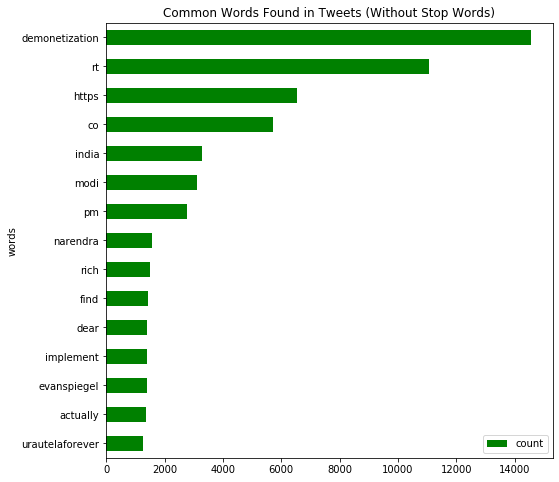

In [27]:
clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="green")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()

## Remove some other words which are occuring in almost every tweets

In [70]:
collection_words = ['rt', 'co', 'http', 'https', 'j', 'k']
tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]
tweets_nsw_nc[0]

['rssurjewala',
 'critical',
 'question',
 'paytm',
 'informed',
 'demonetization',
 'edict',
 'pm',
 'clearly',
 'fishy',
 'requires',
 'full',
 'disclosure']

## Exploring some co-occuring words usinf bi-grams

In [71]:
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw_nc]
terms_bigram[0]

[('rssurjewala', 'critical'),
 ('critical', 'question'),
 ('question', 'paytm'),
 ('paytm', 'informed'),
 ('informed', 'demonetization'),
 ('demonetization', 'edict'),
 ('edict', 'pm'),
 ('pm', 'clearly'),
 ('clearly', 'fishy'),
 ('fishy', 'requires'),
 ('requires', 'full'),
 ('full', 'disclosure')]

## Counting top 20 common bi-grams

In [35]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

[(('narendra', 'modi'), 1566),
 (('india', 'rich'), 1431),
 (('pm', 'narendra'), 1424),
 (('demonetization', 'find'), 1399),
 (('implement', 'demonetization'), 1398),
 (('rich', 'pm'), 1391),
 (('modi', 'implement'), 1376),
 (('evanspiegel', 'india'), 1371),
 (('dear', 'evanspiegel'), 1366),
 (('find', 'actually'), 1311),
 (('urautelaforever', 'dear'), 1273),
 (('narendramodi', 'demonetization'), 595),
 (('pm', 'narendramodi'), 590),
 (('since', 'demonetization'), 572),
 (('rs', 'lakh'), 551),
 (('demonetization', 'terrorists'), 550),
 (('lakh', 'looted'), 544),
 (('looted', 'bank'), 544),
 (('bank', 'kishtwar'), 542),
 (('kishtwar', 'third'), 542)]

## creating a dataframe for visualization of bigrams

In [36]:
#Top 20 most common bigrams
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])
bigram_df

,bigram,count
0,"(narendra, modi)",1566
1,"(india, rich)",1431
2,"(pm, narendra)",1424
3,"(demonetization, find)",1399
4,"(implement, demonetization)",1398
5,"(rich, pm)",1391
6,"(modi, implement)",1376
7,"(evanspiegel, india)",1371
8,"(dear, evanspiegel)",1366
9,"(find, actually)",1311


## Visualizing network of bi-grams using networkx package of python

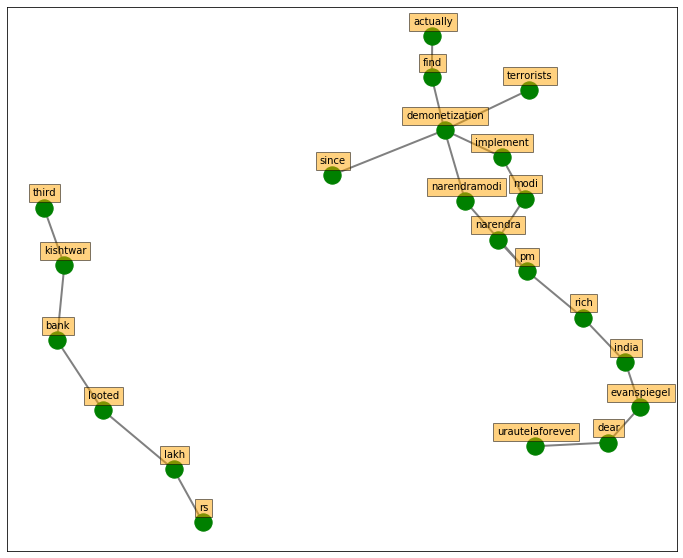

In [39]:
d = bigram_df.set_index('bigram').T.to_dict('records')
G = nx.Graph()
# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 3))

fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=4)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=11,
                 fontweight='bold',
                 width=2,
                 edge_color='grey',
                 node_color='green',
#                  edge_length = 10,
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.00167, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='orange', alpha=0.5),
            horizontalalignment='center', fontsize=10)
    
plt.show()

## Sentiment Analysis using nltk

In [73]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import stopwords
from nltk import tokenize

sid = SentimentIntensityAnalyzer()

tweets['sentiment_compound_polarity']=tweets.text.apply(lambda x:sid.polarity_scores(x)['compound'])
tweets['sentiment_neutral']=tweets.text.apply(lambda x:sid.polarity_scores(x)['neu'])
tweets['sentiment_negative']=tweets.text.apply(lambda x:sid.polarity_scores(x)['neg'])
tweets['sentiment_pos']=tweets.text.apply(lambda x:sid.polarity_scores(x)['pos'])
tweets['sentiment_type']=''
tweets.loc[tweets.sentiment_compound_polarity>0,'sentiment_type']='Positive'
tweets.loc[tweets.sentiment_compound_polarity==0,'sentiment_type']='Neutral'
tweets.loc[tweets.sentiment_compound_polarity<0,'sentiment_type']='Negative'
tweets.head(3)

,Unnamed: 0,X,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,...,isRetweet,retweeted,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type,statusSource_new,statusSource_new2,text_lem
0,1,1,rt rssurjewala critical question paytm informe...,False,0,NaN,2016-11-23 18:40:30,False,NaN,8.014957e+17,...,True,False,0.1027,0.706,0.135,0.159,Positive,Twitter for Android,Twitter for Android,rt rssurjewala critical question paytm informe...
1,2,2,rt hemant vote demonetization modi survey app,False,0,NaN,2016-11-23 18:40:29,False,NaN,8.014957e+17,...,True,False,0.0000,1.000,0.000,0.000,Neutral,Twitter for Android,Twitter for Android,rt hemant vote demonetization modi survey app
2,3,3,rt roshankar former finsec rbi dy governor cbd...,False,0,NaN,2016-11-23 18:40:03,False,NaN,8.014955e+17,...,True,False,0.0000,1.000,0.000,0.000,Neutral,Twitter for Android,Twitter for Android,rt roshankar former finsec rbi dy governor cbd...


## Counting total number of tweets for each category of sentiment
>> ### We can see numer of tweets having Positive sentiment is 6771, neutral sentiment is 4233 and negative sentiment is 3936

In [25]:
tweets.sentiment_type.value_counts()

Positive    6771
Neutral     4233
Negative    3936
Name: sentiment_type, dtype: int64

## Bar Plot for Sentiment Analyis
>>### We can see Positive sentiment is higher than negative sentiment 

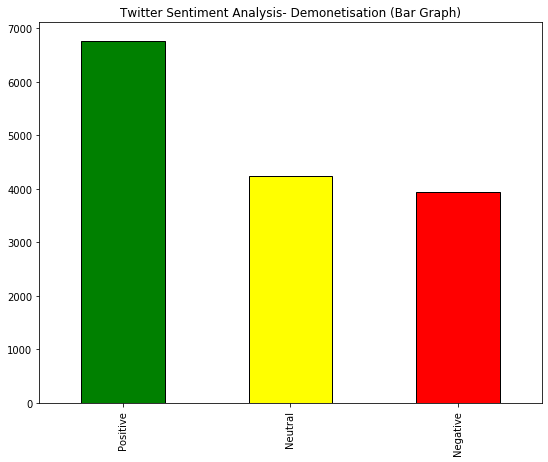

In [26]:
# fig = plt.figure()
# fig.savefig('Sentiment_bar_plot.pdf')
colors = ['green', 'yellow', 'red']
tweets.sentiment_type.value_counts().plot(kind='bar',figsize=(9, 7),edgecolor='k',title="Twitter Sentiment Analysis- Demonetisation (Bar Graph)", color=colors)
# plt.savefig('Sentiment_bar_plot.png', dpi=100)

## Sentiment plot in forms of Pie chart

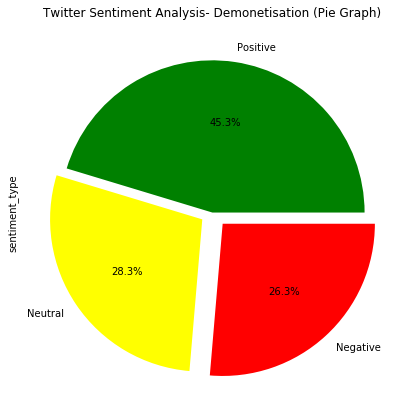

In [27]:
colors = ['green', 'yellow', 'red']
explode = (0, 0.08, 0.1)
tweets.sentiment_type.value_counts().plot(kind='pie', figsize=(9, 7), title="Twitter Sentiment Analysis- Demonetisation (Pie Graph)", colors=colors, explode=explode,autopct='%1.1f%%', shadow=False)
# plt.savefig('Sentiment_pie_plot.png', dpi=100)

## Source of tweets
>> ### We can see the source of tweets corresponding to each index of all 14940 tweets
>> ### From the below pie chart it's clearly visible that, Top 3 of Source: 1 - Twitter For Android 2 - Twitter for Iphones 3 - Twitter for Web Client and finally !

/home/dheeraj/my_projects/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dheeraj/my_projects/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dheeraj/my_projects/my_project_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0        Twitter for Android 
1        Twitter for Android 
2        Twitter for Android 
3        Twitter for Android 
4                      Others
                 ...         
14935    Twitter for Android 
14936    Twitter for Android 
14937    Twitter for Android 
14938     Twitter Web Client 
14939     Twitter Web Client 
Name: statusSource_new2, Length: 14940, dtype: object


Text(0.5, 1.0, 'Number of retweetcount by Source bis')

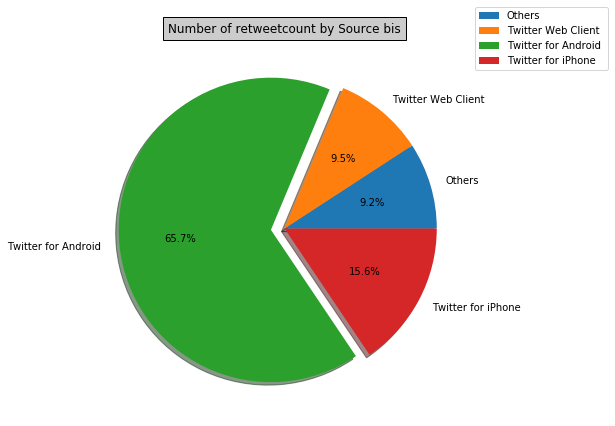

In [47]:
tweets['statusSource_new'] = ''
for i in range(len(tweets['statusSource'])):
    m = re.search('(?<=>)(.*)', tweets['statusSource'][i])
    try:
        tweets['statusSource_new'][i]=m.group(0)
    except AttributeError:
        tweets['statusSource_new'][i]=tweets['statusSource'][i] 
#print(tweets['statusSource_new'].head())   
tweets['statusSource_new'] = tweets['statusSource_new'].str.replace('</a>', ' ', case=False)
tweets['statusSource_new2'] = ''

for i in range(len(tweets['statusSource_new'])):
    if tweets['statusSource_new'][i] not in ['Twitter for Android ','Twitter Web Client ','Twitter for iPhone ']:
        tweets['statusSource_new2'][i] = 'Others'
    else:
        tweets['statusSource_new2'][i] = tweets['statusSource_new'][i] 
print(tweets['statusSource_new2']) 

tweets_by_type2 = tweets.groupby(['statusSource_new2'])['retweetCount'].sum()
tweets_by_type2.rename("",inplace=True)
explode = (0, 0, 0.09, 0)
tweets_by_type2.transpose().plot(kind='pie',figsize=(9, 7),autopct='%1.1f%%',shadow=True,explode=explode)
plt.legend(bbox_to_anchor=(1, 1), loc=6, borderaxespad=0.)
plt.title('Number of retweetcount by Source bis', bbox={'facecolor':'0.8', 'pad':5})

## Clusterig using K-means algorithm 
>> ### We can see the shape of X and 100 clusters generated usig above K-means algorithm

In [72]:
tweets['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in tweets.text]       
####
vectorizer = TfidfVectorizer(max_df=0.5,max_features=10000,min_df=10,stop_words='english',use_idf=True)
X = vectorizer.fit_transform(tweets['text_lem'].str.upper())
print("Shape of X is: ", X.shape, '\n')
print("Clusters are: ", '\n')
km = KMeans(n_clusters=100,init='k-means++',max_iter=200,n_init=1)
km.fit(X)
terms = vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:,::-1]
for i in range(100):
    print("cluster %d:" %i, end='')
    for ind in order_centroids[i,:10]:
        print(' %s' % terms[ind], end='')
    print() 

Shape of X is:  (14940, 1925) 

Clusters are:  

cluster 0: current policy help money people pm modi gandhi gau gates
cluster 1: oscar obqrhlnsl drkumarvishwas goes mr https kumar retweeted dr hazare
cluster 2: ends daughter gujarat fund wedding life ahead man shortage dgai
cluster 3: edict informed critical rssurjewala fishy requires disclosure clearly paytm question
cluster 4: urautelaforever evanspiegel implement dear rich narendra actually pm modi india
cluster 5: kishtwar gauravcsawant incident looted terrorists lakh rs bank https gau
cluster 6: heteyum announcements mib finminindia ch dasshaktikanta india https gandhi gau
cluster 7: flags watched reinstate ge timcast ads videos youtube people money
cluster 8: opinions lacs harshkkapoor amazing hours commitment na fight results response
cluster 9: putting nitishkumar uodwxdpmmg party politics supports modibharosa nation narendramodi pm
cluster 10: prove successful wave adityanath yogi polls result today rahulroushan modi
cluster 1

## From the above reults of sentiment analysis, since number of tweets that have positive sentiment is greater than the negative and neutral sentiment.
> # So we can say that majority of population are in favour of Demonetization, morever they are supporting the government. Hence, we can say our Hypothesis is True